In [0]:
# #Download sample datset from keras
# !rm -rf *
# !wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip -O weather.zip
# !unzip weather.zip
# !rm weather.zip
# !mv jena_climate_2009_2016.csv weather.csv
# clear_output()

In [0]:
from IPython.display import clear_output
!rm -rf *
!wget https://github.com/PvtSec/weatherML/raw/84eedf65cd5a4e2e089464a50e0b4c01d06fc719/Dataset/Delhi-Hourly/clean2.csv -O weather_data.csv
!clear
clear_output()

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
from pylab import rcParams
from scipy.ndimage.filters import gaussian_filter1d

In [117]:
data = pd.read_csv("weather_data.csv")
data.head()

,Index,timestamp,humidity,temperature
0,1,19961101-11:00,27.0,30.0
1,2,19961101-12:00,32.0,28.0
2,3,19961101-13:00,44.0,24.0
3,4,19961101-14:00,41.0,24.0
4,5,19961101-16:00,47.0,23.0


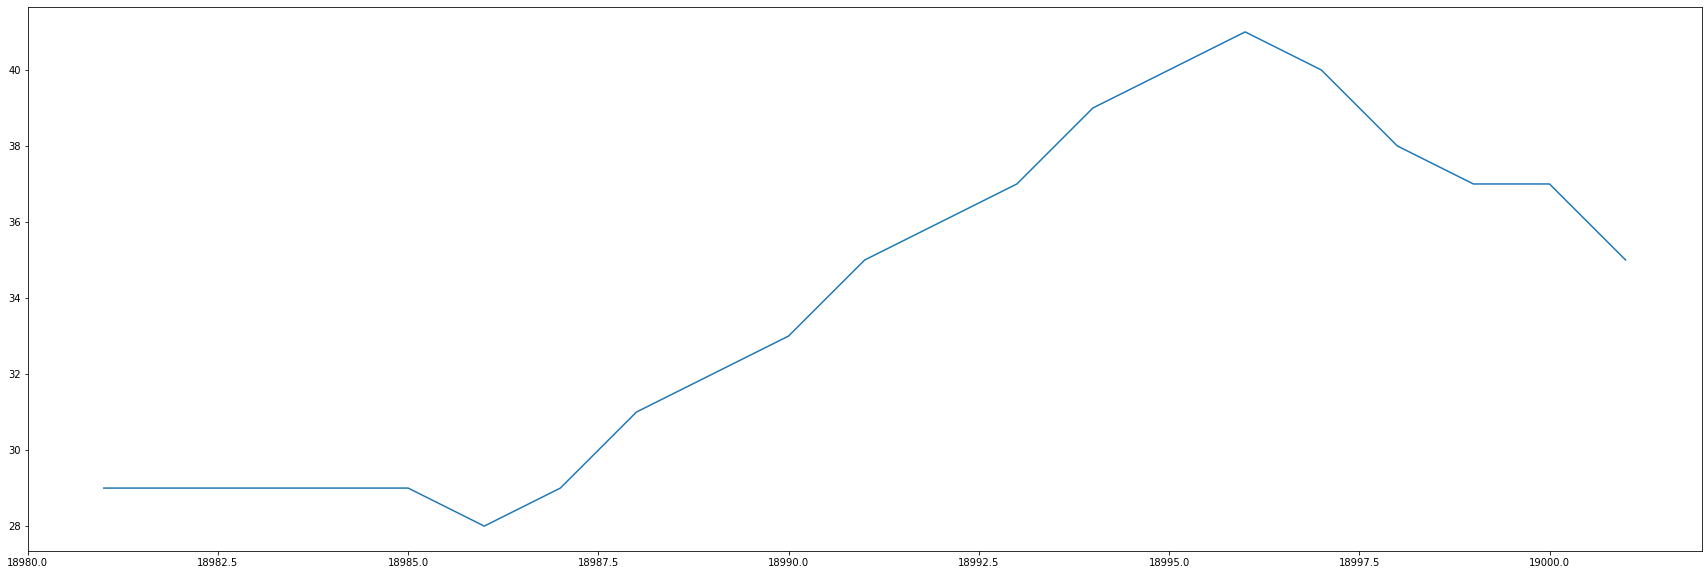

In [132]:
rcParams['figure.figsize'] = 30, 10
temp_data = data['temperature']
temp_data.index = data['Index']
plt.plot(temp_data[18980:19001])

In [0]:
#Split the dataset and get mean, standard deviation, and then standardize the temperature data

split = 20000
temp_data = temp_data.values

temp_mean = temp_data[:split].mean()
temp_stdv = temp_data[:split].std()
temp_std = (temp_data - temp_mean) / temp_stdv


In [0]:
past_data = 19000
target_data = 0

data = []
labels = []

start_index = 0 + past_data
end_index = split

for i in range(start_index, end_index):
  index = range(i-past_data, i)
  data.append(np.reshape(temp_std[index], (past_data, 1)))
  labels.append(temp_std[i+target_data])
x,y = np.array(data), np.array(labels)

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
plot_data = [x[0],y[0]]
delta = 0
labels = ['Previous data', 'Next Real Data', 'Model Prediction']
marker = ['.-', 'rx', 'go']
time_steps = create_time_steps(plot_data[0].shape[0])
if delta:
  future = delta
else:
  future = 0

plt.title("Sample Example")

for i, xe in enumerate(plot_data):
  if i:
    plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
  else:
    plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
plt.legend()
plt.xlim([time_steps[0], (future+5)*2])
plt.xlabel('Time-Step')
#View the last point if previous data and the next real data : convert back to original value
#print(((plot_data[0].flatten()[19])*temp_stdv) + temp_mean)
#print(((plot_data[1])*temp_stdv) + temp_mean)

In [0]:
def baseline(history):
  return np.mean(history)

In [0]:
train_univariate = tf.data.Dataset.from_tensor_slices((x, y))
train_univariate = train_univariate.cache().shuffle(256).batch(10000).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x, y))
val_univariate = val_univariate.batch(256).repeat()

lstm = tf.keras.models.Sequential([tf.keras.layers.LSTM(8, input_shape=x.shape[-2:]), tf.keras.layers.Dense(1)])
lstm.compile(optimizer='adam', loss='mae')

In [0]:
EVALUATION_INTERVAL = 30
EPOCHS = 3

lstm.fit(train_univariate, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_univariate, validation_steps=50)

In [0]:
for xx, yy in val_univariate.take(1):
  plot_data = [xx[0].numpy(), yy[0].numpy(), lstm.predict(xx)[0]]
  delta = 0
  labels = ['Previous values', 'Next Real value', 'Predicted value']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  tymstp = time_steps
  if delta:
    future = delta
  else:
    future = 0
  flatend_data = plot_data[0].flatten()

In [0]:
rcParams['figure.figsize'] = 80, 20
ysmoothed = gaussian_filter1d(flatend_data, sigma=2)

plt.title("LSTM Model")
#plt.axis([100, -100, -3, 3])
plt.plot(tymstp[0:], ysmoothed, marker[0], label=labels[0])
plt.plot(future, plot_data[1], marker[1], markersize=10, label=labels[1])
plt.plot(future, plot_data[2], marker[2], markersize=10, label=labels[2])  
#plt.legend()
plt.xlim([time_steps[0], (future+5)*2])
plt.xlabel('Time-Step')

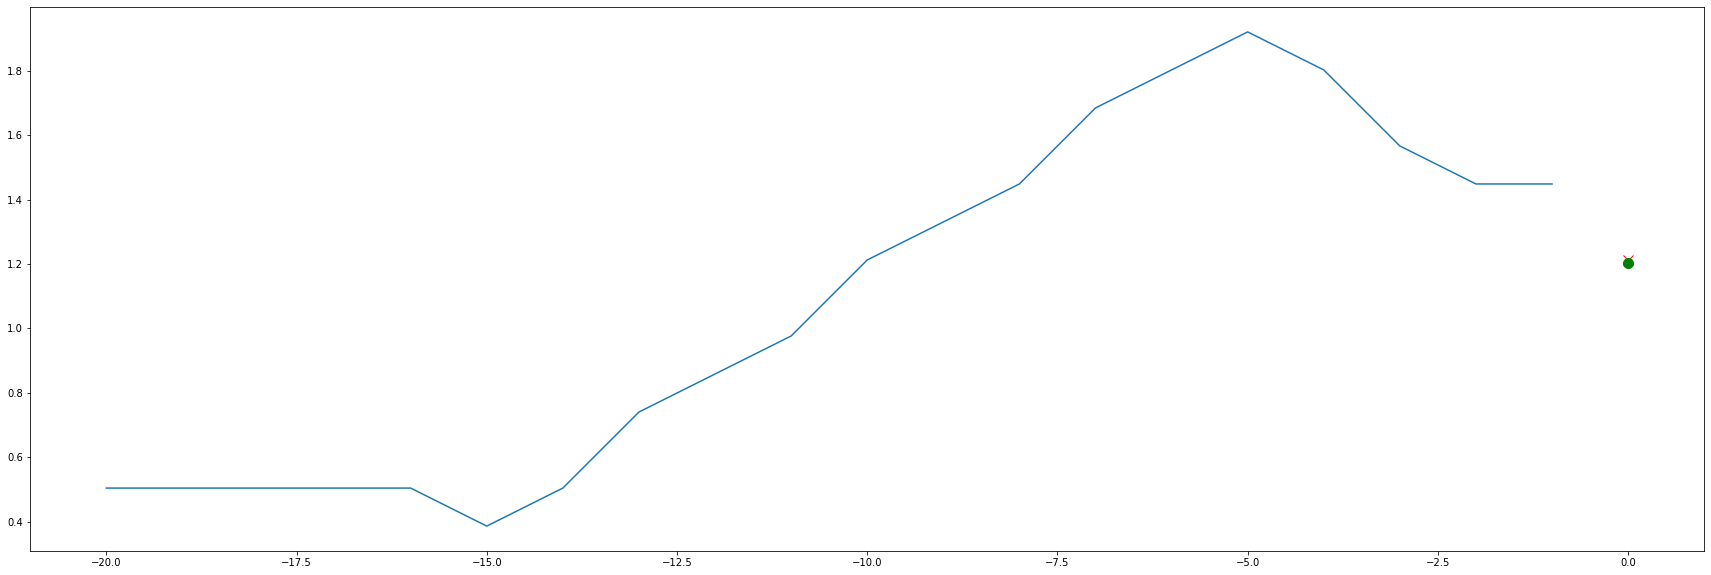

In [128]:
rcParams['figure.figsize'] = 30, 10
xpoint = tymstp[-20:]
ypoint = flatend_data[-20:]
ysmoot = ysmoothed[-20:]
plt.plot(xpoint,ypoint)
plt.plot(future, plot_data[1], marker[1], markersize=10, label=labels[1])
plt.plot(future, plot_data[2], marker[2], markersize=10, label=labels[2])

In [0]:
std_real_future = plot_data[1]
std_pred_future = plot_data[2][0]
#convert standardized value back to temperature
actual = abs((std_real_future * temp_stdv)+temp_mean)
predicted = abs((std_pred_future * temp_stdv)+temp_mean)
error = abs(round(((actual - predicted) / actual)*100,2))
print("Actual    :",round(actual,2),"°C")
print("Predicted :",round(predicted,2),"°C")
print("Error     :",error,"%")

In [0]:
import tempfile
import os

MODEL_DIR = "/content/"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    lstm,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

In [0]:
!zip model_3.zip 1/*